First load in the modules

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Now, lets load in the MNIST dataset. This dataset is a a large dataset with 60.000 training samples and 10.000 test samples of handwritten digits. Notice that in the code below only the features (X) are used. Because we are creating new images, the labels are not necessary. Also note that the data here is normalized first. This is done by dividing the pixel values by 255.

In [2]:
# Load the MNIST dataset
X, _ = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.astype('float32') / 255.0
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

c:\Users\jespe\anaconda3\envs\tf\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


After the data is loaded, the model is created. This code defines an encoder model for a variational autoencoder (VAE). A VAE is a generative model that learns to encode input data into a low-dimensional latent space. Later it  decodes the latent representation back into a reconstruction of the original input. The model has an input shape 784. This is because the images are 28 by 28 pixels and the images are flattened before giving them to the model. The first two layers are Dense layers with the ReLU activation function of 256 and 128 units respectively.  

In [3]:
# Define the encoder model
latent_dim = 2
encoder_inputs = keras.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


The sample function takes the mean and the logistic variance as input. Then, it produces a random sample using the reparameterizion trick. The trick involves introducing a noise variable epsilon that is sampled from a standard normal distribution, and then transforming it using the mean and log-variance vectors. By sampling from a continuous distribution, the VAE can learn a smooth and structured latent space that can be used for tasks such as data generation, interpolation, and manipulation.

In [4]:
# Define the sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])



Now, the decoding model is defined. THis model has the same shape as input as the encoder output layer. The decoder also consists out of two Dense layers with the ReLU activation function with 256 and 128 layers respectively.

In [5]:
# Define the decoder model
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(decoder_inputs)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = layers.Dense(784, activation="sigmoid")(x)

Here, the decoder and encoder are combined to make one variational autoencoder (VAE). 

In [6]:
# Define the VAE model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")

Also, a custom loss function is defined

In [7]:
# Define the loss function
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, vae_outputs)
reconstruction_loss *= 784
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

Here, the model is trained. The model is trained for 50 epochs with a batch size of 128. Also notice that the testing set is used for validation. This is because we dont need a testing set. We try to generate new images so a testing set is not needed.

In [8]:
# Compile the model
vae.compile(optimizer=keras.optimizers.Adam())

# Train the model
vae.fit(X_train, epochs=50, batch_size=128, validation_data=(X_test, None))

Epoch 1/50
438/438 [==============================] - 3s 4ms/step - loss: 191.4817 - val_loss: 166.8244
Epoch 2/50
438/438 [==============================] - 2s 4ms/step - loss: 163.3970 - val_loss: 159.8697
Epoch 3/50
438/438 [==============================] - 2s 4ms/step - loss: 157.7190 - val_loss: 155.0706
Epoch 4/50
438/438 [==============================] - 2s 4ms/step - loss: 153.6990 - val_loss: 152.1873
Epoch 5/50
438/438 [==============================] - 2s 4ms/step - loss: 151.3764 - val_loss: 150.2902
Epoch 6/50
438/438 [==============================] - 2s 4ms/step - loss: 149.7630 - val_loss: 148.8903
Epoch 7/50
438/438 [==============================] - 2s 4ms/step - loss: 148.5252 - val_loss: 147.9464
Epoch 8/50
438/438 [==============================] - 2s 4ms/step - loss: 147.4910 - val_loss: 146.9729
Epoch 9/50
438/438 [==============================] - 2s 4ms/step - loss: 146.6085 - val_loss: 146.1481
Epoch 10/50
438/438 [==============================] - 2s 4ms/st

Here the new samples are generated. In this example, 10 samples are shown. The samples are generated with the help of the tf random function which generates a random variable that is fed into the model. The outputs are then used as new samples. The output is first reshaped so it could be used as images. As can be seen in the generated samples below, the samples look quite similar to the original samples. It is not as good as the original samples but this can be improved by using a better model or training longer.

1/1 [==============================] - 0s 11ms/step


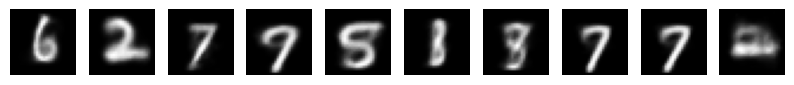

In [10]:
import matplotlib.pyplot as plt

# Generate new samples
n_samples = 10
z = tf.random.normal(shape=(n_samples, latent_dim))
x_decoded = decoder.predict(z)

# Reshape the samples to 28x28 images
x_decoded = x_decoded.reshape(-1, 28, 28)

# Plot the samples
fig, axs = plt.subplots(1, n_samples, figsize=(n_samples, 1))
for i in range(n_samples):
    axs[i].imshow(x_decoded[i], cmap='gray')
    axs[i].axis('off')
plt.show()
